In [1]:
!pip install tensorflow==2.13.0 opencv-python mediapipe scikit-learn matplotlib


Install & import dependencies

In [1]:
import cv2 #opencv
import numpy as np #arrays & structuring datasets
import os #file paths
from matplotlib import pyplot as plt #visualizing images (iamshow)
import time #sleep between frames
import mediapipe as mp #extract keypoints

Keypoints

In [2]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [3]:
def mediapipe_detection(image, model): #image is the frame
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion (BlueGreenRed to RedGreenBlue)
    image.flags.writeable = False #sets image writable status to false
    results = model.process(image) #detecting & making prediction
    image.flags.writeable = True #image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #color conversion
    return image, results #return image and results

In [4]:
def draw_landmarks(image, results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) 
                              )
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )

In [5]:
cap = cv2.VideoCapture(0) #accessing webcam, cap is video capture device
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened(): #loop through all frames in camera
        ret, frame = cap.read() #grab current frame, frame is actual image, ret is return value
        
        image, results = mediapipe_detection(frame, holistic) #make detection
        print(results)
        
        draw_landmarks(image, results)
        
        cv2.imshow("Science Fair", image) #show to screen, opencv feed is name of frame
        
        if cv2.waitKey(10) & 0xFF == ord("q"): #break if current key equals q
            break
    cap.release() #release webcam
    cv2.destroyAllWindows() #close frame

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [6]:
results

mediapipe.python.solution_base.SolutionOutputs

In [7]:
draw_landmarks(frame, results)

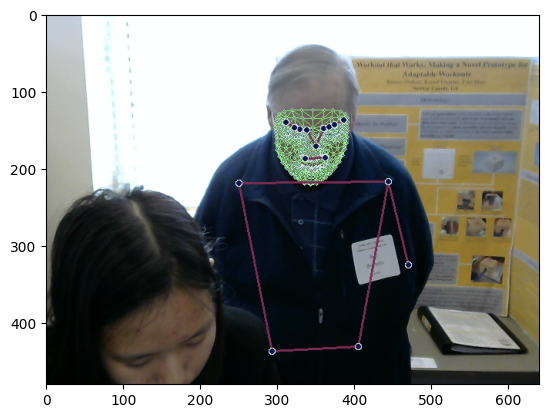

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract keypoint values

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)#appends the np array for every landmark which is res x/y/z
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) #np zeros: replacement when there is no left/right hand in the frame with an empty array with the same shape
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) #486 landmarks with 3 values
    return np.concatenate([pose, face, left_hand, right_hand])

In [10]:
result_test = extract_keypoints(results)

In [11]:
result_test

array([ 0.54794115,  0.35669219, -1.72078347, ...,  0.        ,
        0.        ,  0.        ])

In [12]:
np.save("0", result_test)

In [13]:
np.load("0.npy")

array([ 0.54794115,  0.35669219, -1.72078347, ...,  0.        ,
        0.        ,  0.        ])

Setup folders for collection

In [14]:
DATA_PATH = "C:\ScienceFair\MP_DATA" #path for exported data (numpy arrays)
actions = np.array(['hello', 'thanks', 'iloveyou']) #actions that we're detecting
num_sequences = 30 #30 videos
sequence_length = 30 #each vid is 30 frames

In [15]:
for action in actions: #loop through all actions
    for sequence in range(num_sequences): #loop through 3- difference sequences
        try: #error if they already exist
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            print(f"Successfully created directories for sequence {sequence} of action {action}")
        except:
            pass

Collect keypoint sequences

In [85]:
cap = cv2.VideoCapture(0) #accessing webcam, cap is video capture device
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    for action in actions: #loop through actions
        for sequence in range(num_sequences): #loop through sequences aka videos
            for fram_num in range(sequence_length): #loop through video length
                
                ret, frame = cap.read() #grab current frame, frame is actual image, ret is return value
        
                image, results = mediapipe_detection(frame, holistic) #make detection
                print(results)
        
                draw_landmarks(image, results)
                
                if fram_num == 0:
                    cv2.putText(image, "STARTING COLLECTION", (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA) #font size, color, line width, line type
                    cv2.putText(image, "Collecting frames for {} Video Number {}".format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow("Science Fair", image)
                    cv2.waitKey(2000) #2 seconds
                else:
                    cv2.putText(image, "Collecting frames for {} Video Number {}".format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                    cv2.imshow("Science Fair", image) #show to screen, opencv feed is name of frame
                    
                keypoints = extract_keypoints(results) #extract keypoints
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(fram_num)) #create path to save frame
                np.save(npy_path, keypoints)
                
                if cv2.waitKey(10) & 0xFF == ord("q"): #break if current key equals q
                    break
    cap.release() #release webcam
    cv2.destroyAllWindows() #close frame

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Preprocess Data and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split #parition data into training & testing
from tensorflow.keras.utils import to_categorical #convert data

In [17]:
actions = np.array(['hello', 'iloveyou', 'thanks'])
label_map = {label:num for num, label in enumerate(actions)} #loops through each action

In [18]:
label_map

{'hello': 0, 'iloveyou': 1, 'thanks': 2}

In [19]:
sequences, labels = [], [] #x & y
for action in actions:
    for sequence in range(num_sequences):
        window = [] #all frames
        for fram_num in range(sequence_length): #creates videos
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(fram_num))) #grabbing each frame
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [20]:
np.array(sequences).shape

(90, 30, 1662)

In [21]:
X = np.array(sequences)

In [22]:
y = to_categorical(labels).astype(int)

In [23]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [25]:
np.array(X_train.shape)

array([  85,   30, 1662])

Build and train LSTM neural network

In [26]:
from tensorflow.keras.models import Sequential #sequential neural network
from tensorflow.keras.layers import LSTM, Dense #action detection layer, normal fully connected layer
from tensorflow.keras.callbacks import TensorBoard #logging

In [27]:
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30,1662))) #30 frames & 1662 values in X.shape
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu")) #next layer is dense
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu")) 
model.add(Dense(actions.shape[0], activation="softmax")) #action layer, we have 28 neural network units in this case, softmax makes sum of npargmax 1

In [29]:
res = [.7, .2, .1]

In [30]:
action[np.argmax(res)] #action predicted

't'

In [31]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"]) #optimizer can change, multi-class uses categorical crossentropy

In [126]:
model.fit(X_train, y_train, epochs=120, callbacks=[tb_callback])

Epoch 1/120
3/3 [==============================] - 4s 65ms/step - loss: 0.2145 - categorical_accuracy: 0.9529
Epoch 2/120
3/3 [==============================] - 0s 66ms/step - loss: 0.1522 - categorical_accuracy: 0.9294
Epoch 3/120
3/3 [==============================] - 0s 66ms/step - loss: 0.2258 - categorical_accuracy: 0.8941
Epoch 4/120
3/3 [==============================] - 0s 67ms/step - loss: 0.2147 - categorical_accuracy: 0.9176
Epoch 5/120
3/3 [==============================] - 0s 67ms/step - loss: 0.1000 - categorical_accuracy: 0.9647
Epoch 6/120
3/3 [==============================] - 0s 67ms/step - loss: 0.1616 - categorical_accuracy: 0.9529
Epoch 7/120
3/3 [==============================] - 0s 66ms/step - loss: 0.1249 - categorical_accuracy: 0.9529
Epoch 8/120
3/3 [==============================] - 0s 67ms/step - loss: 0.0909 - categorical_accuracy: 0.9765
Epoch 9/120
3/3 [==============================] - 0s 68ms/step - loss: 0.0787 - categorical_accuracy: 0.9529
Epoch 10/1

mediapipe holistic + LSTM reasoning:
1. LSTM: Current models use a number of CNN layers followed by number of LSTM layers
2. Mediapipe holistic: Dense neural network (fast to train), less data for hyperaccurate model, simpler method (faster detections)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 

Make predictions

In [33]:
res = model.predict(X_test)

1/1 [==============================] - 0s 482ms/step


In [34]:
actions[np.argmax(res[3])]

'iloveyou'

In [35]:
actions[np.argmax(y_test[4])]

'iloveyou'

Save weights

In [36]:
model.save('LSTM motion detection_9')

KeyboardInterrupt: 

In [132]:
del model

In [37]:
model.load_weights('LSTM motion detection_9')

Evaluation using confusion matrix and accuracy

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [39]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [40]:
ytrue = np.argmax(y_test, axis=1).tolist() #converts predictions from one encoded representation to a categorical label
yhat = np.argmax(yhat, axis=1).tolist()

In [41]:
multilabel_confusion_matrix(ytrue,yhat) #confusion matrix (in this case 0,1,2 being hello,thank,ily) [True N, False P], (next line) [False N, True P]

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [42]:
accuracy_score(ytrue, yhat) #test

1.0

In [43]:
res = [.7, 0.2, 0.1] #VERY IMPORTANT

In [44]:
actions[np.argmax(res)]

'hello'

In [ ]:
!pip install PyQt6

In [33]:
import sys
from PyQt6.QtWidgets import QApplication, QWidget, QLabel, QVBoxLayout

Test in real time!!!!!

In [45]:


# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.95

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        key = cv2.waitKey(1) & 0xFF
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]


        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()




<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [156]:
res[np.argmax(res)] > threshold

True

In [157]:
np.expand_dims(X_test[0], axis=0).shape #generates the shape that the model is expecting (1, 30, 1662). allows to pass through 1 sequence

(1, 30, 1662)

In [2]:
import cv2
import numpy as np
import os 
from matplotlib import pyplot as plt
import time 
import mediapipe as mp 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)#appends the np array for every landmark which is res x/y/z
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) #np zeros: replacement when there is no left/right hand in the frame with an empty array with the same shape
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) #486 landmarks with 3 values
    return np.concatenate([pose, face, left_hand, right_hand])

actions = np.array(['hello', 'thanks', 'iloveyou'])
label_map = {label:num for num, label in enumerate(actions)}

actions = np.array(['hello', 'thanks', 'iloveyou']) #actions that we're detecting
num_sequences = 30 #30 videos
sequence_length = 30 #each vid is 30 frames

sequences, labels = [], [] #x & y
for action in actions:
    for sequence in range(num_sequences):
        window = [] #all frames
        for fram_num in range(sequence_length): #creates videos
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(fram_num))) #grabbing each frame
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu")) 
model.add(Dense(actions.shape[0], activation="softmax")) 
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.load_weights('LSTM motion detection_3')
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist() 
yhat = np.argmax(yhat, axis=1).tolist()

#1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 377ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_b

In [1]:

import cv2
import numpy as np
import os
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

# ... (Your existing code)
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image) 
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results 

def draw_landmarks(image, results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) 
                              )
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)#appends the np array for every landmark which is res x/y/z
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) #np zeros: replacement when there is no left/right hand in the frame with an empty array with the same shape
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) #486 landmarks with 3 values
    return np.concatenate([pose, face, left_hand, right_hand])

actions = np.array(['hello', 'thanks', 'iloveyou'])
label_map = {label:num for num, label in enumerate(actions)}

DATA_PATH = "C:\ScienceFair\MP_DATA" #path for exported data (numpy arrays)
actions = np.array(['hello', 'thanks', 'iloveyou']) #actions that we're detecting
num_sequences = 30 #30 videos
sequence_length = 30 #each vid is 30 frames

sequences, labels = [], [] #x & y
for action in actions:
    for sequence in range(num_sequences):
        window = [] #all frames
        for fram_num in range(sequence_length): #creates videos
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(fram_num))) #grabbing each frame
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu")) 
model.add(Dense(actions.shape[0], activation="softmax")) 
res = [.7, .2, .1]
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.load_weights('LSTM motion detection_8')
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist() 
yhat = np.argmax(yhat, axis=1).tolist()

def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image) 
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results 

def draw_landmarks(image, results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) 
                              )
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )
cap = cv2.VideoCapture(0)
class HolisticRecognitionThread(QThread):
    recognition_signal = pyqtSignal(str)

    def __init__(self, parent=None):
        super().__init__(parent)
        self.mp_holistic = mp.solutions.holistic
        self.mp_drawing = mp.solutions.drawing_utils
        self.holistic = self.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    def run(self):
        
        with cap:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                image, results = self.mediapipe_detection(frame)
        
                # Draw landmarks
                draw_landmarks(image, results)
        
                # 2. Prediction logic
                keypoints = extract_keypoints(results)
                sequence.append(keypoints)
                sequence = sequence[-30:]
        
                if len(sequence) == 30:
                    res = model.predict(np.expand_dims(sequence, axis=0))[0]
                    print(actions[np.argmax(res)])
                    predictions.append(np.argmax(res))
            
            
                #3. Viz logic
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5: 
                    sentence = sentence[-5:]

            
                cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
                cv2.putText(image, ' '.join(sentence), (3,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                keypoints = extract_keypoints(results)
                sequence.append(keypoints)
                sequence = sequence[-30:]

                if len(sequence) == 30:
                    res = model.predict(np.expand_dims(sequence, axis=0))[0]
                    recognized_action = actions[np.argmax(res)]
                    self.recognition_signal.emit(recognized_action)

                cv2.imshow('Holistic Recognition', image)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        cap.release()
        cv2.destroyAllWindows()

    def mediapipe_detection(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = self.holistic.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return image, results



1/1 [==============================] - 0s 446ms/step


NameError: name 'QThread' is not defined

In [ ]:
import sys
from PyQt6.QtWidgets import QApplication, QWidget, QVBoxLayout, QLabel, QLineEdit, QPushButton
from PyQt6.QtGui import QImage, QPixmap
from PyQt6.QtCore import QTimer, QThread, pyqtSignal
import cv2
import numpy as np
import os
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# ... (Your existing code)
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image) 
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results 

def draw_landmarks(image, results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) 
                              )
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)#appends the np array for every landmark which is res x/y/z
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) #np zeros: replacement when there is no left/right hand in the frame with an empty array with the same shape
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) #486 landmarks with 3 values
    return np.concatenate([pose, face, left_hand, right_hand])

actions = np.array(['hello', 'iloveyou', 'thankyou'])
label_map = {label:num for num, label in enumerate(actions)}

DATA_PATH = "C:\Science Fair\MP_DATA" #path for exported data (numpy arrays)
actions = np.array(['hello', 'thankyou', 'iloveyou']) #actions that we're detecting
num_sequences = 30 #30 videos
sequence_length = 30 #each vid is 30 frames

sequences, labels = [], [] #x & y
for action in actions:
    for sequence in range(num_sequences):
        window = [] #all frames
        for fram_num in range(sequence_length): #creates videos
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(fram_num))) #grabbing each frame
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu")) 
model.add(Dense(actions.shape[0], activation="softmax")) 
res = [.7, .2, .1]
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.load_weights('LSTM motion detection_3')
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist() 
yhat = np.argmax(yhat, axis=1).tolist()

def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image) 
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results 

def draw_landmarks(image, results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) 
                              )
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )
class HolisticRecognitionThread(QThread):
    recognition_signal = pyqtSignal(str)

    def __init__(self, parent=None):
        super().__init__(parent)
        self.mp_holistic = mp.solutions.holistic
        self.mp_drawing = mp.solutions.drawing_utils
        self.holistic = self.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    def run(self):
        cap = cv2.VideoCapture(0)

        with cap:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                image, results = self.mediapipe_detection(frame)

                # Draw landmarks
                draw_landmarks(image, results)

                # 2. Prediction logic
                keypoints = extract_keypoints(results)
                sequence.append(keypoints)
                sequence = sequence[-30:]

                if len(sequence) == 30:
                    res = model.predict(np.expand_dims(sequence, axis=0))[0]
                    recognized_action = actions[np.argmax(res)]
                    self.recognition_signal.emit(recognized_action)

                cv2.imshow('Holistic Recognition', image)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        cap.release()
        cv2.destroyAllWindows()

    def mediapipe_detection(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = self.holistic.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return image, results


class HolisticRecognitionApp(QWidget):
    def __init__(self):
        super().__init__()

        self.init_ui()

        # Initialize camera capture
        self.cap = cv2.VideoCapture(0)

    def init_ui(self):
        # Create GUI components
        self.image_label = QLabel(self)
        self.image_label.setFixedSize(640, 480)

        self.input_label = QLabel('User Input:', self)
        self.user_input = QLineEdit(self)

        self.start_button = QPushButton('Start', self)
        self.start_button.clicked.connect(self.start_recognition)

        # Layout setup
        layout = QVBoxLayout()
        layout.addWidget(self.image_label)
        layout.addWidget(self.input_label)
        layout.addWidget(self.user_input)
        layout.addWidget(self.start_button)

        self.setLayout(layout)

        self.holistic_thread = HolisticRecognitionThread()
        self.holistic_thread.recognition_signal.connect(self.handle_recognition)

        self.timer = QTimer(self)
        self.timer.timeout.connect(self.update_frame)
        self.timer.start(10)

    def update_frame(self):
        ret, frame = self.cap.read()
        q_image = self.convert_cv_image_to_qt_image(frame)
        self.image_label.setPixmap(QPixmap.fromImage(q_image))

    def start_recognition(self):
        user_input_text = self.user_input.text()
        print(f"User Input: {user_input_text}")

        if not self.holistic_thread.isRunning():
            self.holistic_thread.start()

    def handle_recognition(self, recognized_action):
        print(f"Recognized Action: {recognized_action}")

    def convert_cv_image_to_qt_image(self, cv_image):
        height, width, channel = cv_image.shape
        bytes_per_line = 3 * width
        qt_image = QImage(cv_image.data, width, height, bytes_per_line, QImage.Format_RGB888)
        return qt_image

    def closeEvent(self, event):
        self.timer.stop()
        if self.holistic_thread.isRunning():
            self.holistic_thread.quit()
            self.holistic_thread.wait()
        self.cap.release()  # Release the camera capture

        event.accept()


def main():
    app = QApplication(sys.argv)
    recognition_app = HolisticRecognitionApp()
    recognition_app.setWindowTitle('Holistic Recognition App')
    recognition_app.show()
    sys.exit(app.exec())


if __name__ == '__main__':
    main()


In [6]:
!pip install pyqt6

  Using cached PyQt6-6.6.0-cp37-abi3-win_amd64.whl.metadata (2.2 kB)
  Using cached PyQt6_sip-13.6.0.tar.gz (111 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 2
  ╰─> [433 lines of output]
        Using cached setuptools-68.0.0-py3-none-any.whl.metadata (6.4 kB)
        Using cached wheel-0.41.3-py3-none-any.whl.metadata (2.2 kB)
      Using cached setuptools-68.0.0-py3-none-any.whl (804 kB)
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ---------------------------------------- 0.0/65.8 kB ? eta -:--:--
         ----------------

In [ ]:
import sys
from PyQt6.QtWidgets import QApplication, QWidget, QVBoxLayout, QLabel, QLineEdit, QPushButton
from PyQt6.QtGui import QImage, QPixmap
from PyQt6.QtCore import QTimer, QThread, pyqtSignal
import cv2
import numpy as np
import os
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

# ... (Your existing code)
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = model.process(image) 
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results 

def draw_landmarks(image, results):
    #draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) 
                              )
    #draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,10), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                              )
    #draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)#appends the np array for every landmark which is res x/y/z
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) #np zeros: replacement when there is no left/right hand in the frame with an empty array with the same shape
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) #486 landmarks with 3 values
    return np.concatenate([pose, face, left_hand, right_hand])

actions = np.array(['hello', 'iloveyou', 'thankyou'])
label_map = {label:num for num, label in enumerate(actions)}

DATA_PATH = "C:\Science Fair\MP_DATA" #path for exported data (numpy arrays)
actions = np.array(['hello', 'thankyou', 'iloveyou']) #actions that we're detecting
num_sequences = 30 #30 videos
sequence_length = 30 #each vid is 30 frames

sequences, labels = [], [] #x & y
for action in actions:
    for sequence in range(num_sequences):
        window = [] #all frames
        for fram_num in range(sequence_length): #creates videos
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(fram_num))) #grabbing each frame
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu")) 
model.add(Dense(actions.shape[0], activation="softmax")) 
res = [.7, .2, .1]
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.load_weights('LSTM motion detection_3')
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist() 
yhat = np.argmax(yhat, axis=1).tolist()

cap = cv2.VideoCapture(0)
class HolisticRecognitionThread(QThread):
    recognition_signal = pyqtSignal(str)
    def mediapipe_detection(image, model): 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = model.process(image) 
        image.flags.writeable = True 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        return image, results 

    def __init__(self, parent=None):
        super().__init__(parent)
        self.mp_holistic = mp.solutions.holistic
        self.mp_drawing = mp.solutions.drawing_utils
        self.holistic = self.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    def run(self):
        recognition_signal = pyqtSignal(str)

    def __init__(self, parent=None):
        super().__init__(parent)
        self.mp_holistic = mp.solutions.holistic
        self.mp_drawing = mp.solutions.drawing_utils
        self.holistic = self.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    def run(self):
        cap = cv2.VideoCapture(0)

        with cap:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                image, results = self.mediapipe_detection(frame)

                # Draw landmarks
                draw_landmarks(image, results)

                # 2. Prediction logic
                keypoints = extract_keypoints(results)
                sequence.append(keypoints)
                sequence = sequence[-30:]

                if len(sequence) == 30:
                    res = model.predict(np.expand_dims(sequence, axis=0))[0]
                    recognized_action = actions[np.argmax(res)]
                    self.recognition_signal.emit(recognized_action)

                cv2.imshow('Holistic Recognition', image)

    cap.release()
    cv2.destroyAllWindows()

class HolisticRecognitionApp(QWidget):
    def __init__(self):
        super().__init__()

        self.init_ui()

        # Initialize camera capture
        self.cap = cv2.VideoCapture(0)

    def init_ui(self):
        # Create GUI components
        self.image_label = QLabel(self)
        self.image_label.setFixedSize(640, 480)

        self.input_label = QLabel('User Input:', self)
        self.user_input = QLineEdit(self)

        self.start_button = QPushButton('Start', self)
        self.start_button.clicked.connect(self.start_recognition)

        # Layout setup
        layout = QVBoxLayout()
        layout.addWidget(self.image_label)
        layout.addWidget(self.input_label)
        layout.addWidget(self.user_input)
        layout.addWidget(self.start_button)

        self.setLayout(layout)

        self.holistic_thread = HolisticRecognitionThread()
        self.holistic_thread.recognition_signal.connect(self.handle_recognition)

        self.timer = QTimer(self)
        self.timer.timeout.connect(self.update_frame)
        self.timer.start(10)

    def update_frame(self):
        ret, frame = self.cap.read()
        # Call mediapipe_detection from HolisticRecognitionThread
        image, results = self.holistic_thread.mediapipe_detection(frame)

        # Draw landmarks
        draw_landmarks(image, results)

        q_image = self.convert_cv_image_to_qt_image(image)
        self.image_label.setPixmap(QPixmap.fromImage(q_image))
        # Get image with landmarks drawn
        image, results = self.holistic_thread.mediapipe_detection(frame)
        draw_landmarks(image, results)

        # Convert the image to Qt format
        q_image = self.convert_cv_image_to_qt_image(image)

    def start_recognition(self):
        user_input_text = self.user_input.text()
        print(f"User Input: {user_input_text}")

        if not self.holistic_thread.isRunning():
            self.holistic_thread.start()

    def handle_recognition(self, recognized_action):
        print(f"Recognized Action: {recognized_action}")

    def convert_cv_image_to_qt_image(self, cv_image):
        height, width, channel = cv_image.shape
        bytes_per_line = 3 * width
        qt_image = QImage(cv_image.data, width, height, bytes_per_line, QImage.Format.Format_RGB888)

        return qt_image

    def closeEvent(self, event):
        self.timer.stop()
        if self.holistic_thread.isRunning():
            self.holistic_thread.quit()
            self.holistic_thread.wait()
        self.cap.release()  # Release the camera capture

        event.accept()

def main():
    app = QApplication(sys.argv)
    recognition_app = HolisticRecognitionApp()
    recognition_app.setWindowTitle('Holistic Recognition App')
    recognition_app.show()
    sys.exit(app.exec())


if __name__ == '__main__':
    main()

